In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import StudentT
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import math
from scipy.stats import norm
from collections import defaultdict
from random import uniform
from tqdm import tqdm
import scipy.stats
from scipy.integrate import quad
from torch.optim.optimizer import Optimizer, required

In [2]:
class ArbitraryMomentumSGD(Optimizer):
    def __init__(self, params, lr=required, momentum_schedule=None):
        """
        Custom SGD that accepts arbitrary momentum (can be negative or >1).
        
        Arguments:
        - params: model parameters
        - lr: learning rate
        - momentum_schedule: callable or float.
            If callable: should return momentum given current step.
            If float: fixed momentum value.
        """
        defaults = dict(lr=lr, momentum_schedule=momentum_schedule, step=0)
        super(ArbitraryMomentumSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            step = group['step']
            momentum_schedule = group['momentum_schedule']

            # Evaluate momentum
            if callable(momentum_schedule):
                momentum = momentum_schedule(step)
            else:
                momentum = momentum_schedule

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                # Initialize velocity if not present
                state = self.state[p]
                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)

                v = state['velocity']
                v.mul_(momentum).add_(d_p, alpha=-lr)
                p.data.add_(v)

            # Increment step counter
            group['step'] += 1

        return loss

In [3]:
class SuperModel(nn.Module):
    def __init__(self, asset_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len,
                 pre_heads, time_heads, asset_heads,
                 value_size, dropout=0.0):
        super().__init__()

        self.asset_out_size = asset_size
        self.value_size = value_size
        self.h_size = h_size
        self.seq_len = seq_len

        self.base_model = MultiTimescaleLSTM(asset_size, h_size, n_layers, batch_size, seq_len,
                                             pre_heads, time_heads, asset_heads,
                                             value_size, dropout)
        
        self.volume_head = VolumeMetaHead(volume_h_size, dropout)
        
    def forward(self, x):
        """ x: [B, A, V + 1, T] """
        # <== Reshape data ==>
        volume = x[:, :, 5, :]                       # [B, A, T]
        ohlc = x[:, :, :5, :]                        # [B, A, V, T]
        
        ohlc = ohlc.transpose(1, 3)                  # [B, T, V, A] (Transpose for lstm)
        B, T, V, A = ohlc.shape
        
        log_volume = torch.log1p(volume)

        # <== get model predictions ==>
        mu, sigma, nu, skew = self.base_model(ohlc)
        volume_correction = self.volume_head(log_volume)

        # === Calculate Volume Head Corrections ===            
        mu_vol_corr = volume_correction[:, :, 0, :].mean(dim=-1) # [B, A]
        sigma_vol_corr = volume_correction[:, :, 1, :] # [B, A, 2]
        nu_vol_corr = volume_correction[:, :, 2, :] # [B, A, 2]
                
        # === Apply Corrections ===
        corr_scale = 0.2
        mu = mu + corr_scale*mu_vol_corr
        sigma = F.relu(sigma + corr_scale*sigma_vol_corr) + 1e-2
        nu = F.relu(nu + corr_scale*nu_vol_corr) + 2.0
        
        return mu, sigma, nu, skew    

In [4]:
class SpatioTemporalCausalAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_assets, num_timesteps):
        super().__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.output_proj = nn.Linear(embed_dim, embed_dim)
        self.num_assets = num_assets
        self.num_timesteps = num_timesteps

        # Precompute causal time mask
        t = num_timesteps
        a = num_assets
        time_ids = torch.arange(t).repeat(a)  # [A*T]
        mask = time_ids[None, :] <= time_ids[:, None]
        self.register_buffer("causal_mask", (~mask).float() * float('-inf'))  # [A*T, A*T]

    def forward(self, x):
        B, A, T, V = x.shape
        x = x.permute(0, 2, 1, 3).reshape(B, A*T, V)  # [B, A*T, V]
        x = self.embed(x)
    
        # Recreate the mask dynamically in case T is variable
        time_ids = torch.arange(T, device=x.device).repeat(A)
        mask = time_ids[None, :] <= time_ids[:, None]
        causal_mask = (~mask).float() * float('-1e9')  # [A*T, A*T]
    
        attn_out, _ = self.attn(x, x, x, attn_mask=causal_mask)
        x_proj = self.output_proj(attn_out)
        
        return x_proj.reshape(B, T, A, -1).permute(0, 2, 1, 3)  # [B, A, T, E]

In [5]:
class MultiTimescaleLSTM(nn.Module):
    def __init__(self, asset_size, h_size, n_layers, batch_size, seq_len,
                 pre_heads, time_heads, asset_heads,
                 value_size, dropout=0.0):
        super().__init__()

        self.h_size = h_size

        # === Layer Norms ===
        self.hidden_norm = nn.LayerNorm(normalized_shape=h_size)
        self.seq_norm = nn.LayerNorm(normalized_shape=seq_len)

        # === Attention Modules ===
        print(f"Value size: {value_size}, Asset size: {asset_size}")
        self.pre_attn = nn.MultiheadAttention(embed_dim=value_size*asset_size, num_heads=pre_heads, batch_first=True)
        """
        self.spatio_temporal_attn = SpatioTemporalCausalAttention(
            input_dim=value_size,
            embed_dim=h_size,
            num_heads=pre_heads,
            num_assets=asset_size,
            num_timesteps=seq_len
        )
        """
        self.temporal_attn = nn.MultiheadAttention(embed_dim=h_size, num_heads=time_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim=seq_len, num_heads=asset_heads, batch_first=True)

        # === LSTM ===
        self.lstm = nn.LSTM(
            input_size=asset_size * value_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )

        # === Linear Layers ===
        self.pre_fc = nn.Sequential(
            nn.Linear(asset_size * value_size, int(asset_size*value_size*0.5)),
            nn.ReLU(),
            nn.Linear(int(asset_size*value_size*0.5), asset_size * value_size)
        )
        self.post_fc = nn.Linear(seq_len * h_size, 4 * asset_size * 2)

    def forward(self, ohlc):
        """
        ohlc: [B, T, V, A]
        """
        H = self.h_size
        B, T, V, A = ohlc.shape

        ohlc_flat = ohlc.reshape(B, T, A*V)
        #pre_fc = self.pre_fc(ohlc_flat)
        #x = x.transpose(2, 3)  # -> [B, A, T, V]

        # === Spatio-Temporal Attention ===
        #x_attn = self.spatio_temporal_attn(x)  # [B, A, T, H]
        #x_attn = x_attn.transpose(1, 2)          # [B, T, A, H]
        #B, T, A, H = x_attn.shape
        #x_flat = x_attn.reshape(B, T, A * H)     # [B, T, A*H]

        # === Pre Attention ===
        
        # === LSTM ===
        lstm_out, _ = self.lstm(ohlc_flat)          # [B, T, H]
        lstm_out = self.hidden_norm(lstm_out)

        pre_attn, _ = self.pre_attn(ohlc_flat, ohlc_flat, ohlc_flat)
        pre_attn_lstm, _ = self.lstm(pre_attn)
        pre_attn_lstm = self.hidden_norm(pre_attn_lstm)

        lstm_out = lstm_out + pre_attn_lstm  
        device = lstm_out.device

        # === Temporal Attention with Causal Mask ===
        causal_mask = torch.triu(torch.full((T, T), float('-inf')), diagonal=1).to(device) # [B, T, H]
        temp_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out, attn_mask=causal_mask) # [B, T, H]
        temp_out = self.hidden_norm(temp_out + lstm_out)

        # === Cross-Asset Attention ===
        temp_out = temp_out.reshape(B, H, T)
        asset_out, _ = self.cross_attn(temp_out, temp_out, temp_out)  # [B, H, T]
        asset_out = self.seq_norm(asset_out + temp_out) # [B, H, T]

        # === Reshape and post fc
        asset_flat = asset_out.reshape(B, T * H) # [B, T*H]
        final = self.post_fc(asset_flat) # [B, 4 * A * 2]
        final = final.view(B, A, 4, 2)

        # === Output Parameters ===
        mu       = final[:, :, 0, :].mean(dim=-1)  # [B, A]
        log_sigma = final[:, :, 1, :] # [B, A, K]
        log_nu    = final[:, :, 2, :] # [B, A, K]
        skew = final[:, :, 3, 0] - final[:, :, 3, 1] # [B, A]

        sigma = torch.exp(log_sigma)
        nu = torch.exp(log_nu)
        skew = torch.tanh(0.1 * skew)

        return mu, sigma, nu, skew

In [6]:
class VolumeMetaHead(nn.Module):
    def __init__(self, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(8, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 16),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(16, 3 * 2),
        )

    def forward(self, log_volume):
        """
        log_vol: [B, A, T]
        Returns:
            correction: [B, A, out_per_asset]
        """
        # Average across time: create a regime signal per asset
        avg_vol = log_volume.mean(dim=-1, keepdim=True)  # [B, A, 1]
        correction = self.fc(avg_vol)                 # [B, A, out_per_asset]

        B, A, _ = correction.shape
        correction = correction.reshape(B, A, 3, 2)
        return correction

In [7]:
def mixture_student_t_logpdf(x, mus, sigmas, nus, dist_weights):
    """
    Log-likelihood of Mixture of Student-t Distributions.

    Inputs:
        x:           [B, A]       target returns
        mus:         [B, A, K]    mixture component means
        sigmas:      [B, A, K]    std deviations (> 0)
        nus:         [B, A, K]    degrees of freedom (> 2)
        dist_weights:[B, A, K]    mixture weights (normalized)

    Returns:
        log_prob:    [B, A]       log-likelihood of each sample
    """
    x = x.unsqueeze(-1)  # [B, A, 1] to broadcast over K
    t_dist = StudentT(df=nus, loc=mus, scale=sigmas)
    log_pdf = t_dist.log_prob(x)       # [B, A, K]
    log_w = F.log_softmax(dist_weights, dim=-1)  # [B, A, K]
    
    return torch.logsumexp(log_pdf + log_w, dim=-1)  # [B, A]

In [8]:
def mixture_student_t_loss(mu, sigma, nu, skew, target, deviation=(100., 0.)):
    """
    Loss from Mixture of Skewed Student-t Distributions.

    Inputs:
        mu:     [B, A, 2]   Means of two Student-t components
        sigma:  [B, A, 2]   Standard deviations (positive)
        nu:     [B, A, 2]   Degrees of freedom (> 2)
        skew:   [B, A]      Skew factor per sample
        target: [B, A]      Target values

    Returns:
        loss:   scalar      Negative log-likelihood loss
    """
    # Compute mixture weights using skew
    skew_input = torch.stack([skew, -skew], dim=-1)  # [B, A, 2]
    dist_weights = F.softmax(skew_input, dim=-1)     # [B, A, 2]

    # Adjust mu for skew
    mu_adj = torch.stack([mu - skew, mu + skew], dim=-1)

    # Log-likelihood
    log_probs = mixture_student_t_logpdf(target, mu_adj, sigma, nu, dist_weights)  # [B, A]
    pdf_loss = -log_probs.mean()

    # Optional: mixture entropy
    entropy = -torch.sum(dist_weights * torch.log(dist_weights + 1e-8), dim=-1).mean()

    return pdf_loss + 0.0 * entropy

In [9]:
class StockDataset():
    def __init__(self, root_dir, seq_len=1024, num_days=1):
        self.seq_len = seq_len
        self.num_days = num_days
        self.root_dir = root_dir
        self.files = self.get_filenames()
        self.data = self.load_data()

    def get_filenames(self):
        files = os.listdir(self.root_dir)
        return files
    
    def load_data(self):
        # Array of dimension [stock name, price category(open, close, high, low, close, volume, date), sequence length]
        data = np.zeros((len(self.files), 7, self.seq_len // self.num_days))
        
        for i, filename in enumerate(self.files):
            
            with open(self.root_dir + '/' + filename, 'r', encoding="utf-8") as file:
                #print(filename)
                #head = file.read(1000)
                #print(head)  # if this looks binary, it's not a JSON file!
                file.seek(0)
                content = json.load(file)
                time_series = content["Time Series (Daily)"]

                df = pd.DataFrame.from_dict(time_series, orient='index')
                df.columns = ['open', 'high', 'low', 'close', 'volume']
                df.index = pd.to_datetime(df.index)
                df = df.apply(pd.to_numeric, errors='coerce')

                o = df[['open']].to_numpy()
                c = df[['close']].to_numpy()
                h = df[['high']].to_numpy()
                l = df[['low']].to_numpy()
                v = df[['volume']].to_numpy()
                t = df.index.to_numpy()

                # All data is aranged from oldest to newest date
                # So we first have to flip the data by [::-1]
                data[i, 0, :] = (o.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 o.flatten()[self.num_days:self.seq_len + self.num_days][::-1][::self.num_days] - 1)
                data[i, 1, :] = (c.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 c.flatten()[self.num_days:self.seq_len + self.num_days][::-1][::self.num_days] - 1)
                data[i, 2, :] = (h.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 h.flatten()[self.num_days:self.seq_len + self.num_days][::-1][::self.num_days] - 1)
                data[i, 3, :] = (l.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 l.flatten()[self.num_days:self.seq_len + self.num_days][::-1][::self.num_days] - 1)
                data[i, 5, :] = (v.flatten()[:self.seq_len][::-1][::self.num_days])

                # convert date to unix time
                dates = t.flatten()[:self.seq_len][::-1][::self.num_days]
                data[i, 6, :] = dates.astype('datetime64[s]')
                data[i, 6, :] = data[i, 6, :].astype('int64')

                file.close()

            # extra statistics
            data[:, 4, :] = data[:, 2, :] - data[:, 3, :] # daily range high - low
    
        return data

    def scale_log(self):
        self.data = np.log(1 + self.data)
        return 0

    def average(self, decay_fac=0.0):
        
        avg_arr = np.zeros_like(self.data)
        
        for i in range(self.seq_len):
            exp_decay = np.exp(-decay_fac * np.arange(0, self.seq_len - i))
            exp_decay = exp_decay[::-1]
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.repeat(exp_decay, repeats=len(self.files), axis=0)
            exp_decay = np.repeat(exp_decay, repeats=5, axis=1)
            avg_arr[:,:-1,i] = np.sum(self.data[:,:-1,i:] * exp_decay, axis=-1) / np.sum(exp_decay[:,:,:], axis=-1)
        
        avg_arr[:,-1,:] = self.data[:,-1,:].copy()

        return avg_arr

    def recons_absol(self):
        # this function only provides a test to reconstruct the original shape of the stock prices
        abs_data = np.zeros_like(self.data)
        abs_data[:,:,0] = 1.
        abs_data[:,-1,:] = self.data[:,-1,:]
        # iterate over all timesteps after the first
        for j in range(self.data.shape[2] - 1):
            abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])

        return abs_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

['LMT.json', 'BMW.DE.json', 'FRE.DE.json', 'ENR.DE.json', 'DAI.DE.json', 'SAP.DE.json', 'DHER.DE.json', 'AAPL.json', 'HOT.DE.json', 'RHM.DE.json', 'BAYN.DE.json', 'MUV2.DE.json', 'BAS.DE.json', 'ADS.DE.json', 'DBK.DE.json', 'ALV.DE.json', 'SIE.DE.json', 'DTE.DE.json']
Train: 15.05%
Validation: 19.47%
Test: 30.11%
num stocks: 18


/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_20119/3362156596.py:91: RuntimeWarning: overflow encountered in multiply
  abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])


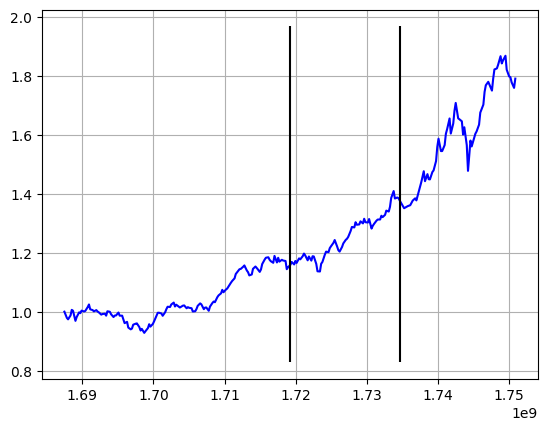

In [10]:
num_days=2 # How many days is each datapoint?

#root_dir = "/Users/silas/work/machine_learning/LSTM/data/data_dump"
root_dir = "/Users/silas/work/machine_learning/LSTM/data/my_repo"
stock_data = StockDataset(root_dir, seq_len=512, num_days=num_days)

stock_nr = 3

print(stock_data.files)
#plt.plot(stock_data.data[stock_nr,-1,:], stock_data.data[stock_nr,0,:])

abs_data = stock_data.recons_absol()
x = abs_data[stock_nr,-1,:]
y = np.mean(abs_data[:,0,:], axis=0)

val_idx = int(0.5*len(x))
test_idx = int(0.75*len(x))

val_cut = x[val_idx]
test_cut = x[test_idx]

train_data = y[:val_idx]
val_data = y[val_idx:test_idx]
test_data = y[test_idx:]

for arr, text in zip([train_data, val_data, test_data], ["Train", "Validation", "Test"]):
    interval_return = arr[-1] / arr[0] -1
    print(f"{text}: {interval_return:.2%}")

num_stocks = len(stock_data.files)
print(f"num stocks: {num_stocks}")
buy_and_hold = interval_return

plt.plot(x, y, color="blue")
plt.grid()
plt.vlines([val_cut, test_cut], np.min(y) - 0.1, np.max(y) + 0.1, color="black")
plt.show()

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_stock_idx, max_deviation=False):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len
        self.max_deviation = max_deviation

    def __len__(self):
        return self.data.shape[-1] -self.seq_len

    def __getitem__(self, idx):
        x = self.data[:, :, idx : idx + self.seq_len]
        # Mask input data !!! Not Target !!!
        #if self.max_deviation != False:
        #    x = torch.where(torch.abs(x) > self.max_deviation, 0.0, x)
        y = self.data[:, target_stock_idx, idx + self.seq_len]
        return x, y

In [12]:
def split_time_series(data, train_ratio=0.5, val_ratio=0.25):
    time_steps = data.shape[-1]
    #print(f"Time steps: {time_steps}")
    train_end = int(time_steps * train_ratio)
    val_end = int(time_steps * (train_ratio + val_ratio))
    return data[:, :, 0:train_end], data[:, :, train_end:val_end], data[:, :, val_end:]

In [13]:
def get_warmup_cosine_scheduler(optimizer, warmup_steps, plateau_steps, total_steps, lr_max):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return current_step / warmup_steps
        elif (current_step >= warmup_steps) & (current_step <  warmup_steps + plateau_steps):
            return 1.0
        else:
            progress = (current_step - warmup_steps - plateau_steps) / (total_steps - warmup_steps - plateau_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

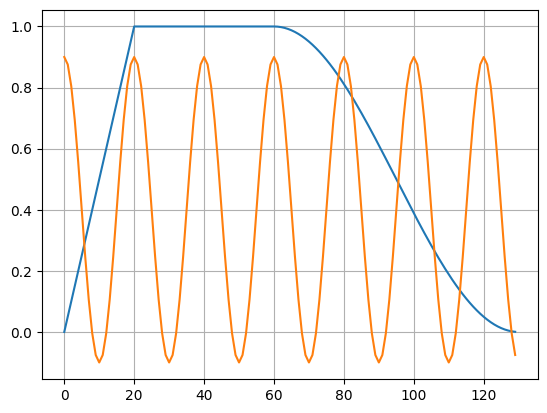

In [14]:
def cyclic_momentum(step):
    return 0.4 + 0.5 * np.cos(2 * np.pi * step / 20)

dummy_warmup_steps = 20
dummy_plateau_steps = 40
dummy_total_steps = 130
dummy_lr = np.zeros(dummy_total_steps)
dummy_momentum = np.zeros(dummy_total_steps)
dummy_steps = np.arange(0, dummy_total_steps, 1)

for step in dummy_steps:
    
    if step < dummy_warmup_steps:
        dummy_lr[step] = step / dummy_warmup_steps
    elif (step >= dummy_warmup_steps) & (step < dummy_warmup_steps + dummy_plateau_steps):
        dummy_lr[step] = 1.0
    else:
        progress = (step - dummy_warmup_steps - dummy_plateau_steps) / (dummy_total_steps - dummy_warmup_steps - dummy_plateau_steps)
        dummy_lr[step] = 0.5 * (1 + math.cos(math.pi * progress))

    dummy_momentum[step] = cyclic_momentum(step)

plt.plot(dummy_steps, dummy_lr)
plt.plot(dummy_steps, dummy_momentum)
plt.grid()
plt.show()

In [15]:
# lstm model parameters
h_size = num_stocks
n_layers = 3

pre_heads = 5
time_heads = 2
asset_heads = 2

dropout = 0.3
seq_len = 16
batch_size = 1
deviation = (100.00, 0.0) # target deviation in loss function

num_experts = 5

# Meta head parameters
volume_h_size = 24
metrics_h_size = 32

# training main model
warmup_steps = 5
plateau_steps = 60
total_steps = 70
momentum_cycle = 20
lr_max=1e-4
weight_decay = 0.0
momentum = 0.85

# Training online learning model
lr_single = 1e-5
weight_decay_single = 0.0 #1e-6
momentum_single = 0.9

# Evaluation params
allow_short=False

In [16]:
data = stock_data.data[:,:6,:] # Pass OHLC

target_stock_idx = 1 # [open, close, high, low, volume, datetime]

value_size = data.shape[1] -1 # OHLC
in_size = len(stock_data.files) # number of stocks

print(f"Stock dimension: {stock_data.data.shape}")
print(f"Value size: {value_size}")

Stock dimension: (18, 7, 256)
Value size: 5


In [17]:
train_ratio = 0.5
val_ratio = 0.25
max_deviation = 0.25 # Mask extreme data

###############
#### Data #####
###############
train, val, test = split_time_series(data, train_ratio=train_ratio, val_ratio=val_ratio)
print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

train_ds = TimeSeriesDataset(train, seq_len, target_stock_idx, max_deviation)
val_ds = TimeSeriesDataset(val, seq_len, target_stock_idx, max_deviation)
test_ds = TimeSeriesDataset(test, seq_len, target_stock_idx, max_deviation)
#print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

# (Batch, in_size, seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Shapes: train=(18, 6, 128) val=(18, 6, 64) test=(18, 6, 64)


In [18]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"device: {device}")

device: cpu


In [19]:
for i_exp in range(num_experts):
    
    torch.manual_seed(torch.initial_seed() + i_exp)

    model = SuperModel(in_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len, pre_heads, 
                           time_heads, asset_heads, value_size, dropout).to(device)
    torch.save({
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
        }, f"{i_exp}_pre_trained.pth")

optimizer = ArbitraryMomentumSGD(
    model.parameters(),
    lr=lr_max,
    momentum_schedule=lambda step: momentum + 0.0 * torch.cos(2 * torch.pi * torch.tensor(step) / torch.tensor(momentum_cycle))  # Cyclic μ in [-0.1, 0.9]
)

scheduler = get_warmup_cosine_scheduler(
    optimizer, warmup_steps=warmup_steps, plateau_steps=plateau_steps, total_steps=total_steps, lr_max=lr_max
)

Value size: 5, Asset size: 18
Value size: 5, Asset size: 18
Value size: 5, Asset size: 18
Value size: 5, Asset size: 18
Value size: 5, Asset size: 18


In [20]:
def calc_correct_preds(test_data, mu, sigma, nu, dist_weights, threshold):

    sigma = np.where(nu > 2, np.sqrt(nu / (nu-2)) * sigma, 1e10)
    
    # signal to noise ratio
    s_n = np.abs(mu) / sigma

    significant_out = np.where(s_n > threshold, np.where(mu > 0, 1, -1), 0.)

    samples = np.sum((significant_out * test_data) != 0)
    correct_sign = np.sum((significant_out * test_data) > 0.)

    return samples, correct_sign

In [21]:
def calc_alloc_return(
    mu, sigma, nu, skew, real_returns,
    cash_threshold=0.5,
    temp=0.01,
    apply_confidence_mask=True,
    min_prob=0.5,
    max_loss=10.0,
    invest_sigmoid_scale=10.0,
    allow_short=False,
    x_grid_points=2000
):
    B, A, K = nu.shape  # batch, assets, components
    device = mu.device

    # Add synthetic 'cash' asset
    mu = torch.cat([mu, torch.zeros(B, 1, device=device)], dim=1)
    sigma = torch.cat([sigma, torch.ones(B, 1, K, device=device) * 0.01], dim=1)
    nu = torch.cat([nu, torch.full((B, 1, K), 100.0, device=device)], dim=1)
    skew = torch.cat([skew, torch.full((B, 1), 0.0, device=device)], dim=1)
    real_returns = torch.cat([real_returns, torch.zeros(B, 1, device=device)], dim=1)

    mu_adj = torch.stack([mu - skew, mu + skew], dim=-1)

    def mix_pdf(x_grid):
        X = x_grid.shape[0]
        B, A, K = nu.shape
    
        # Create full grid: [X, B, A]
        x = x_grid[:, None, None].expand(-1, B, A).reshape(-1)  # [X*B*A]
    
        # Prepare all inputs as [X*B*A, K]
        mu_exp   = mu.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
        sigma_exp = sigma.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
        nu_exp    = nu.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
    
        # Expand skew and apply to mu
        skew_input = torch.stack([skew, -skew], dim=-1)  # [B, A, 2]
        dist_weights = F.softmax(skew_input, dim=-1)     # [B, A, 2]
        mu_adj_exp = mu_adj.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
        weights_exp = dist_weights.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
    
        # Evaluate PDF
        log_probs = mixture_student_t_logpdf(x, mu_adj_exp, sigma_exp, nu_exp, weights_exp)  # [X*B*A]
        return log_probs.reshape(X, B, A).exp()  # [X, B, A]

    def integrate(x, y):
        return torch.trapz(y, x, dim=0)  # ∫_x y dx → [B, A]

    # Main grid for gains and probabilities
    x_grid = torch.linspace(-10., 10., x_grid_points, device=device)
    pdf = mix_pdf(x_grid)  # [x, B, A]

    pos_mask = (x_grid > 0).float()[:, None, None]  # [x, 1, 1]
    pos_prob = integrate(x_grid, pdf * pos_mask)    # [B, A]
    exp_gain = integrate(x_grid, pdf * x_grid[:, None, None])  # [B, A]

    # Compute downside risk
    x_loss = torch.linspace(-10., -0.05, x_grid_points, device=device)
    pdf_loss = mix_pdf(x_loss)
    loss_prob = integrate(x_loss, pdf_loss)  # [B, A]

    #print(pos_prob)

    if apply_confidence_mask:
        pos_prob *= (pos_prob > min_prob).float()
        # You may also re-enable risk masking:
        pos_prob *= (loss_prob < max_loss).float()

    # Cash threshold handling
    pos_prob[:, -1] = cash_threshold
    #print(pos_prob[:, -1])
    #print(pos_prob)
    
    # Softmax allocation based on confidence
    alloc_raw = F.softmax(pos_prob / temp, dim=-1)  # [B, A+1]
    #print(alloc_raw)
    #print()

    # Determine total investment ratio
    mu_mean = mu_adj.mean(dim=2)  # [B, A+1]
    max_sig = pos_prob[:, :-1].max(dim=1, keepdim=True)[0]  # [B, 1]
    #invest_ratio = torch.sigmoid((max_sig - cash_threshold) * invest_sigmoid_scale)  # [B, 1]

    allocations = alloc_raw #* invest_ratio  # [B, A+1]

    # Portfolio return computation
    if allow_short:
        returns = torch.where(mu_mean > 0, real_returns, -real_returns)
    else:
        returns = real_returns * (mu_mean > 0).float()

    port_ret = (allocations * returns).sum(dim=1)  # [B]

    return allocations, port_ret

In [22]:
def compute_bootstrap_metrics(returns: torch.Tensor, n_bootstrap: int = 1000, ci: float = 0.95):
    """
    Compute bootstrapped performance metrics (CI) using torch.
    
    Args:
        returns (torch.Tensor): 1D tensor of daily returns.
        n_bootstrap (int): Number of bootstrap samples.
        ci (float): Confidence interval (e.g. 0.95).
    
    Returns:
        dict: {metric: (mean, lower_ci, upper_ci)}
    """
    assert returns.dim() == 1, "Returns must be 1D"
    returns = returns.detach()
    device = returns.device
    N = returns.shape[0]
    alpha = 1 - ci

    metrics = {
        'daily_return': [],
        'cumulative_return': [],
        'annualized_return': [],
        'sharpe_ratio': [],
        'max_drawdown': []
    }

    for _ in range(n_bootstrap):
        # Resample with replacement
        idx = torch.randint(0, N, (N,), device=device)
        sample = returns[idx]

        mean_r = sample.mean()
        std_r = sample.std(unbiased=False)
        sharpe = mean_r / (std_r + 1e-8) * torch.sqrt(torch.tensor(252.0, device=device))

        equity = torch.cumprod(1 + sample, dim=0)
        cum_return = equity[-1] - 1
        annual_ret = equity[-1].pow(252.0 / N * num_days) - 1

        peak = torch.cummax(equity, dim=0)[0]
        drawdown = (equity - peak) / (peak + 1e-8)
        max_dd = drawdown.min()

        metrics['daily_return'].append(mean_r.item())
        metrics['cumulative_return'].append(cum_return.item())
        metrics['annualized_return'].append(annual_ret.item())
        metrics['sharpe_ratio'].append(sharpe.item())
        metrics['max_drawdown'].append(max_dd.item())

    def summarize(values: list[float]):
        values = torch.tensor(values)
        mean = values.mean().item()
        lower = values.kthvalue(int((alpha / 2) * n_bootstrap))[0].item()
        upper = values.kthvalue(int((1 - alpha / 2) * n_bootstrap))[0].item()
        return mean, lower, upper

    return {k: summarize(v) for k, v in metrics.items()}

In [23]:
def calc_performance_metrics(returns: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Differentiable performance metrics using PyTorch ops.
    Assumes returns are daily returns as a 1D tensor.
    """
    # Ensure shape [N]
    returns = returns.view(-1)

    # Cumulative equity curve
    equity_curve = torch.cumprod(1 + returns, dim=0)

    # Annualized return
    total_return = equity_curve[-1]
    annualized_return = total_return.pow(252 / (returns.size(0) * num_days)) - 1

    # Sharpe ratio (risk-free rate = 0)
    sharpe_ratio = returns.mean() / (returns.std(unbiased=False) + 1e-8) * torch.sqrt(torch.tensor(252.0, device=returns.device))

    # Max drawdown
    rolling_max, _ = torch.cummax(equity_curve, dim=0)
    drawdowns = (equity_curve - rolling_max) / (rolling_max + 1e-8)
    max_drawdown = drawdowns.min()

    return sharpe_ratio, max_drawdown, annualized_return, equity_curve

In [24]:
##################
#### Training ####
##################

# Set some parameters for the calc_alloc_return function
train_cash_threshold = 0.53
train_temp = 0.1
train_min_prob = 0.50
train_max_loss = 10.0
train_invest_sigmoid_scale = 5

returns_buffer = []

# Train LSTM model
for train_step in range(total_steps):
        
    all_train_losses = []
    all_val_losses = []

    for i_exp in range(num_experts):

        # load all models
        checkpoint = torch.load(f"{i_exp}_pre_trained.pth")
        model.load_state_dict(checkpoint["model_state_dict"])
        #optimizer.load_state_dict(checkpoint[f'optimizer_state_dict'])
        
        # Training
        model.train()
        
        for batch_x, batch_y in train_loader:
                
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
    
            B, A, V, T = batch_x.shape
    
            # Generate a random permutation of assets
            perm = torch.randperm(A, device=batch_x.device)
            
            # Apply same permutation to both tensors along dim=1
            batch_x = batch_x[:, perm, :, :]
            batch_y = batch_y[:, perm]
    
            # train stock predictor
            optimizer.zero_grad()
            mu, sigma, nu, skew = model(batch_x)
            loss = mixture_student_t_loss(mu, sigma, nu, skew, batch_y, deviation)
    
            loss.backward()
    
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.05)
        
            optimizer.step()
            all_train_losses.append(loss.item())

        torch.save({
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
        }, f"{i_exp}_pre_trained.pth")

    scheduler.step()
    avg_train_loss = np.mean(all_train_losses)

    # Validation
    val_loss = 0

    returns_buffer = []
    total_ret, sample_count = 0, 0
    
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        mu = torch.zeros((num_experts, B, in_size))
        sigma = torch.zeros((num_experts, B, in_size, 2))
        nu = torch.zeros((num_experts, B, in_size, 2))
        skew = torch.zeros((num_experts, B, in_size))

        loss = torch.zeros(num_experts)
        
        for i_exp in range(num_experts):

            # load all models
            checkpoint = torch.load(f"{i_exp}_pre_trained.pth")
            model.load_state_dict(checkpoint["model_state_dict"])

            model.eval()

            mu[i_exp, :, :], sigma[i_exp, :, :, :], nu[i_exp, :, :, :], skew[i_exp, :, :] = model(val_x)
            loss[i_exp] = mixture_student_t_loss(mu[i_exp], sigma[i_exp], nu[i_exp], skew[i_exp], val_y, deviation).item()

        mu_std = mu.std(dim=0)
        mu = mu.mean(dim=0) # [B, A]
        sigma = sigma.mean(dim=0) # [B, A, 2]
        nu = nu.mean(dim=0)
        skew = skew.mean(dim=0)
            
        all_val_losses.append(loss.mean())

        alloc, port_ret = calc_alloc_return(
            mu, sigma, nu, skew, val_y,
            cash_threshold=train_cash_threshold,
            temp=train_temp,
            apply_confidence_mask=True,
            min_prob=train_min_prob,
            max_loss=train_max_loss,
            invest_sigmoid_scale=train_invest_sigmoid_scale,
            allow_short=allow_short
        )
        
        returns_buffer.append(port_ret)  # accumulate tensors directly
        total_ret += port_ret.sum().item()
        sample_count += port_ret.shape[0]

    returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad
    
    sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)
                        
    avg_val_loss = np.mean(all_val_losses)
            
    if (train_step % 5 == 4):
        
        group = optimizer.param_groups[0]
        step = group['step']
        momentum_schedule = group['momentum_schedule']
        current_momentum = momentum_schedule(step)

        print(f"<========== Training metrics ==========>")
        print(f"Step              : {train_step+1}/{total_steps}")
        print(f"LR in microns     : {scheduler.get_last_lr()[0]*10e6:.1f}")
        print(f"Current Momentum  : {current_momentum:.2f}")
        print()
        print(f"Train Loss        : {avg_train_loss:.4f}")
        print(f"Validation Loss   : {avg_val_loss:.4f}")
        print(f"mu std            : {mu_std[0, :].mean(dim=-1):.4f}")
        print(f"<========== Quick Validation set Performance ==========>")
        print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
        print(f"Annualized return: {annualized_return:.2%}")
        print(f"Sharpe ratio: {sharpe_ratio:.2f}")
        print(f"Max drawdown: {max_drawdown:.2%}")
        print(f"mu: {mu.mean():.4f} [{mu.min():.4f}, {mu.max():.4f}]")
        print(f"sigma: {sigma.mean():.4f} [{sigma.min():.4f}, {sigma.max():.4f}]")
        print(f"nu: {nu.mean():.4f} [{nu.min():.4f}, {nu.max():.4f}]")
        print(f"Skew: {skew.mean():.4f} [{skew.min():.4f}, {skew.max():.4f}]")
        print()

<========== Training metrics ==========>
Step              : 5/70
LR in microns     : 1000.0
Current Momentum  : 0.85

Train Loss        : 1.1911
Validation Loss   : 1.1801
mu std            : 0.3507
<========== Quick Validation set Performance ==========>
Final cumulative return: 12.72%
Annualized return: 251.48%
Sharpe ratio: 4.07
Max drawdown: -3.78%
mu: -0.0692 [-0.3911, 0.2095]
sigma: 1.2907 [0.7322, 2.0350]
nu: 3.1224 [2.6353, 4.3586]
Skew: 0.0025 [-0.0651, 0.0803]

<========== Training metrics ==========>
Step              : 10/70
LR in microns     : 1000.0
Current Momentum  : 0.85

Train Loss        : 1.1357
Validation Loss   : 1.1232
mu std            : 0.3247
<========== Quick Validation set Performance ==========>
Final cumulative return: 12.29%
Annualized return: 237.81%
Sharpe ratio: 3.98
Max drawdown: -4.01%
mu: -0.0673 [-0.3698, 0.1681]
sigma: 1.2505 [0.7061, 1.9722]
nu: 3.1265 [2.6381, 4.3576]
Skew: 0.0024 [-0.0648, 0.0800]

<========== Training metrics ==========>
Step

In [29]:
model = SuperModel(in_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len, pre_heads, 
                   time_heads, asset_heads, value_size, dropout=0.0).to(device)

optimizer = ArbitraryMomentumSGD(
    model.parameters(),
    lr=lr_max,
    momentum_schedule=lambda step: 0.99 + 0.0 * torch.tensor(step)  # Cyclic μ in [-0.1, 0.9]
)

for i_exp in range(num_experts):
    
    checkpoint = torch.load(f"{i_exp}_pre_trained.pth")
    model.load_state_dict(checkpoint["model_state_dict"])

    torch.save({
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
        }, f"{i_exp}_trained.pth")

Value size: 5, Asset size: 18


In [30]:
##############################
#### single step learning ####
##############################

cash_threshold = 0.55
temp = 0.005
min_prob = 0.50
max_loss = 0.50
invest_sigmoid_scale = 5

allow_short = False

# Training Parameters
lr_single = 1e-4
weight_decay_single = 0.0
momentum_single = 0.99

# Adapt optimizer parameters
optimizer.param_groups[0]['lr'] = lr_single
optimizer.param_groups[0]['weight_decay'] = weight_decay_single
optimizer.param_groups[0]['momentum'] = momentum_single

# Now first calculate performance and the train

returns_buffer = []
allocs_buffer = []
total_ret, sample_count = 0, 0

train_loss = 0
              
for batch_x, batch_y in test_loader:

    ######################
    ### first evaluate ###
    ######################
    mu = torch.zeros((num_experts, B, in_size))
    sigma = torch.zeros((num_experts, B, in_size, 2))
    nu = torch.zeros((num_experts, B, in_size, 2))
    skew = torch.zeros((num_experts, B, in_size))

    for i_exp in range(num_experts):
        
        checkpoint = torch.load(f"{i_exp}_trained.pth")
        model.load_state_dict(checkpoint["model_state_dict"])
        
        model.eval()
    
        mu[i_exp, :, :], sigma[i_exp, :, :, :], nu[i_exp, :, :, :], skew[i_exp, :, :] = model(batch_x)

    mu = mu.mean(dim=0) # [B, A]
    sigma = sigma.mean(dim=0) # [B, A, 2]
    nu = nu.mean(dim=0)
    skew = skew.mean(dim=0)

    alloc, port_ret = calc_alloc_return(mu, sigma, nu, skew, batch_y, 
                                        cash_threshold=cash_threshold,
                                        temp=temp,
                                        apply_confidence_mask=True,
                                        min_prob=min_prob,
                                        max_loss=max_loss,
                                        invest_sigmoid_scale=invest_sigmoid_scale,
                                        allow_short=allow_short)

    returns_buffer.append(port_ret)  # accumulate tensors directly
    allocs_buffer.append(alloc)
    total_ret += port_ret.sum().item()
    sample_count += port_ret.shape[0]

    ##################
    ### Then train ###
    ##################
    for i_exp in range(num_experts):

        checkpoint = torch.load(f"{i_exp}_trained.pth")
        model.load_state_dict(checkpoint["model_state_dict"])
        
        model.train()
    
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # train stock predictor
        optimizer.zero_grad()
        mu, sigma, nu, skew = model(batch_x)
        loss = mixture_student_t_loss(mu, sigma, nu, skew, batch_y, deviation)
    
        train_loss += loss.item()
    
        loss.backward()
        optimizer.step()

        torch.save({
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
        }, f"{i_exp}_trained.pth")

avg_train_loss = train_loss / len(val_loader)

returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad
sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)

print(f"<========== Online Learaning Performance ==========>")
print(f"Loss                   : {avg_train_loss:.4f}")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Annualized return      : {annualized_return:.2%}")
print(f"Sharpe ratio           : {sharpe_ratio:.2f}")
print(f"Max drawdown           : {max_drawdown:.2%}")
print(f"mu                     : {mu.mean():.4f} [{mu.min():.4f}, {mu.max():.4f}]")
print(f"sigma                  : {sigma.mean():.4f} [{sigma.min():.4f}, {sigma.max():.4f}]")
print(f"nu                     : {nu.mean():.4f} [{nu.min():.4f}, {nu.max():.4f}]")
print(f"Skew                   : {skew.mean():.4f} [{skew.min():.4f}, {skew.max():.4f}]")

<========== Online Learaning Performance ==========>
Loss                   : 1.5084
Final cumulative return: 9.71%
Annualized return      : 164.67%
Sharpe ratio           : 3.00
Max drawdown           : -5.53%
mu                     : 0.0531 [-0.1331, 0.3250]
sigma                  : 0.6562 [0.0100, 3.8670]
nu                     : 2.9986 [2.1903, 4.8684]
Skew                   : 0.0289 [-0.1222, 0.1270]


In [31]:
print(f"\n<========== Final Test Performance ==========>")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Buy and Hold return: {buy_and_hold:.2%}")
print(f"Annualized return: {annualized_return:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")

print(f"\n<========== S&P 500 Performance ==========>")
print(f"Final cumulative return: {0.285 * len(equity_curve) / 390:.2%}")
print(f"Annualized return: 18.9%")
print(f"Sharpe ratio: 1.40")
print(f"Max drawdown: -8%")

print()
print(f"Number of samples: {len(equity_curve)}")

print(f"\n<========== Bootstrap results ==========>")
results = compute_bootstrap_metrics(returns_tensor, n_bootstrap=1000, ci=0.95)
for name, (mean_val, low, high) in results.items():
    print(f"{name.replace('_', ' ').title()}: {mean_val*100:.2f}% "
          f"[{low*100:.2f}%, {high*100:.2f}%]")


<========== Final Test Performance ==========>
Final cumulative return: 9.71%
Buy and Hold return: 30.11%
Annualized return: 164.67%
Sharpe ratio: 3.00
Max drawdown: -5.53%

<========== S&P 500 Performance ==========>
Final cumulative return: 3.51%
Annualized return: 18.9%
Sharpe ratio: 1.40
Max drawdown: -8%

Number of samples: 48

<========== Bootstrap results ==========>
Daily Return: 0.19% [-0.07%, 0.51%]
Cumulative Return: 9.49% [-3.63%, 27.13%]
Annualized Return: 234.70% [-32.18%, 1143.79%]
Sharpe Ratio: 274.89% [-155.70%, 637.18%]
Max Drawdown: -3.79% [-8.43%, -1.41%]


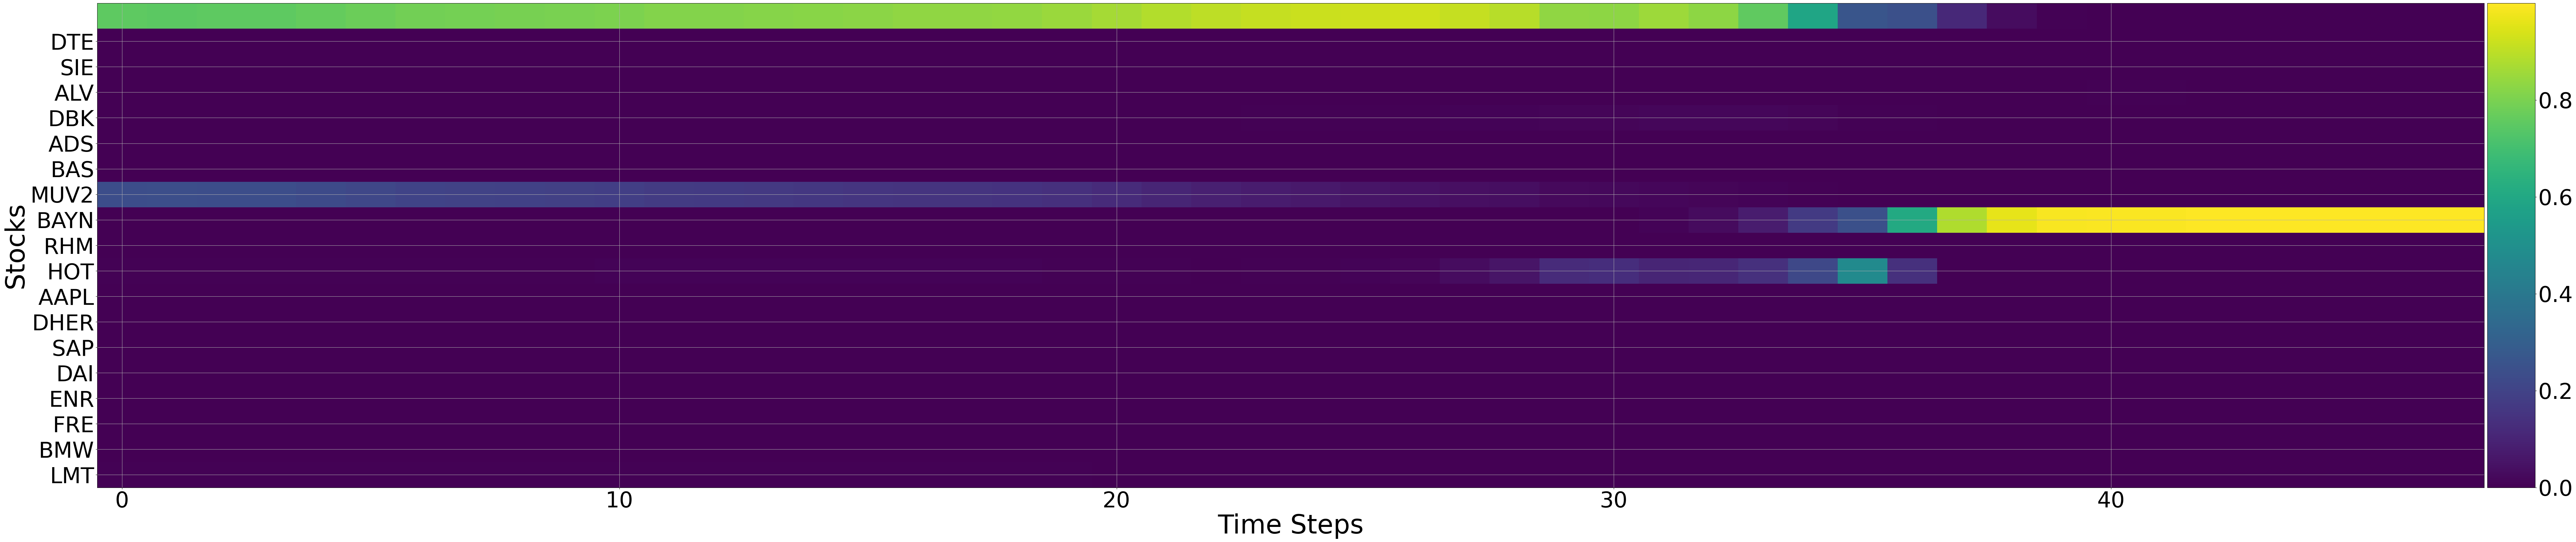

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

stock_names = [filename.split(".")[0] for filename in stock_data.files]

# Assuming all_allocs and stock_data are already defined
allocs_tensor = torch.cat(allocs_buffer, dim=0)
allocs_tensor = allocs_tensor.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(100, 20))  # Large figure

# Use make_axes_locatable to attach a smaller colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)  # Smaller colorbar

# Plot heatmap
image = ax.imshow(allocs_tensor.T, origin="lower", vmin=0, aspect="auto")

# Colorbar with bigger font
cb = plt.colorbar(image, cax=cax)
cb.ax.tick_params(labelsize=50)

# Bigger tick labels on y-axis
ax.set_yticks(range(len(stock_names)))
ax.set_yticklabels(stock_names, rotation=0, ha="right", rotation_mode="anchor", fontsize=50)

# Bigger tick labels on x-axis
ax.tick_params(axis="x", labelsize=50)

# Bigger axis labels if needed
ax.set_xlabel("Time Steps", fontsize=60)
ax.set_ylabel("Stocks", fontsize=60)

ax.grid()

plt.show()